In [107]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-cuvn5s59
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-cuvn5s59
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


In [108]:
!/usr/local/cuda/bin/nvcc --version
#!pip install --upgrade git+https://github.com/frehseg/nvcc4jupyter.git
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!cuda-install-samples-11.2.sh ~ && cd /root/NVIDIA_CUDA-11.2_Samples/

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-fbiqhmir
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-fbiqhmir
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin
/bin/bash: line 1: cuda-install-samples-11.2.sh: command not found


In [109]:
%%cuda --name my_curand.cu
#include <iostream>
#include <vector>
#include <numeric>
#include <chrono>

// CUDA kernel для сложения элементов вектора на GPU
__global__ void sumVectorGPU(const int *a, int *result, const int size) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    if (tid < size) {
        atomicAdd(result, a[tid]);
    }
}

// Функция для сложения элементов вектора на CPU
double sumVectorCPU(const std::vector<int>& a) {
    auto start_time = std::chrono::high_resolution_clock::now();

    int sum = std::accumulate(a.begin(), a.end(), 0);

    auto end_time = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed_time = end_time - start_time;
    return elapsed_time.count();
}

int main() {
    const int vectorSize = 1000000; // Размер вектора

    // Создаем вектор на CPU
    std::vector<int> a(vectorSize, 1);

    // Вызываем функцию сложения на CPU
    double cpu_time = sumVectorCPU(a);

    // Создаем и копируем вектор на GPU
    int *d_a, *d_result;
    cudaMalloc((void**)&d_a, vectorSize * sizeof(int));
    cudaMalloc((void**)&d_result, sizeof(int));
    cudaMemcpy(d_a, a.data(), vectorSize * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemset(d_result, 0, sizeof(int));

    // Вычисляем блоки и потоки для GPU
    const int blockSize = 256;
    const int numBlocks = (vectorSize + blockSize - 1) / blockSize;

    // Вызываем ядро CUDA для сложения элементов вектора на GPU
    auto start_gpu = std::chrono::high_resolution_clock::now();
    sumVectorGPU<<<numBlocks, blockSize>>>(d_a, d_result, vectorSize);
    cudaDeviceSynchronize();
    auto end_gpu = std::chrono::high_resolution_clock::now();

    // Копируем результат с GPU на CPU
    int gpu_result;
    cudaMemcpy(&gpu_result, d_result, sizeof(int), cudaMemcpyDeviceToHost);

    // Освобождаем память на GPU
    cudaFree(d_a);
    cudaFree(d_result);

    // Вычисляем время на GPU
    std::chrono::duration<double> gpu_elapsed_time = end_gpu - start_gpu;
    double gpu_time = gpu_elapsed_time.count();

    // Выводим результаты
    std::cout << "CPU Sum: " << gpu_result << ", Time: " << cpu_time << " seconds\n";
    std::cout << "GPU Sum: " << gpu_result << ", Time: " << gpu_time << " seconds\n";

    return 0;
}

'File written in /content/src/my_curand.cu'

In [110]:
!nvcc -o /content/src/my_curand /content/src/my_curand.cu -lcurand -lcublas

In [111]:
!/content/src/my_curand

CPU Sum: 1000000, Time: 0.0101151 seconds
GPU Sum: 1000000, Time: 0.000249069 seconds


In [55]:
!pip install matplotlib

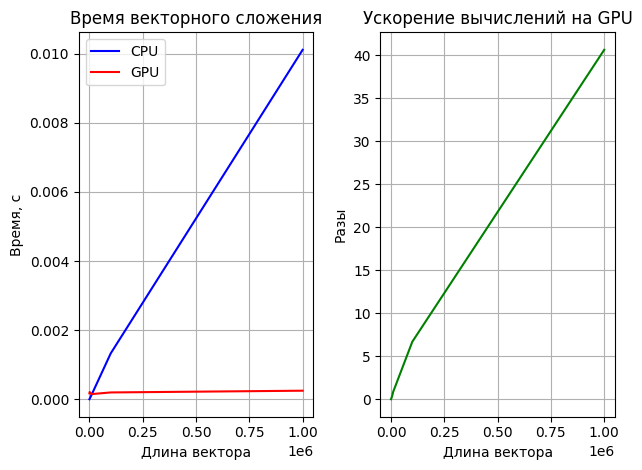

In [113]:
from matplotlib import pyplot as plt
%matplotlib inline

size = [100, 1000, 5000, 10000, 100000, 1000000]
gpu_time = [0.000172694, 0.000210106, 0.00018843, 0.000151483, 0.000198729, 0.000249069]
cpu_time = [1.731e-06, 1.3996e-05, 6.3135e-05, 0.000128716, 0.00132984, 0.0101151]

assert len(size) == len(gpu_time)
assert len(size) == len(cpu_time)

acceleration = [cpu / gpu for cpu, gpu in zip(cpu_time, gpu_time)]

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(size, cpu_time, label='CPU', color='b')
axes[0].plot(size, gpu_time, label='GPU', color='r')
axes[0].grid(True)
axes[0].legend()
axes[0].set_xlabel("Длина вектора")
axes[0].set_ylabel("Время, с")
axes[0].set_title("Время векторного сложения")

axes[1].plot(size, acceleration, color='g')
axes[1].grid(True)
axes[1].set_xlabel("Длина вектора")
axes[1].set_ylabel("Разы")
axes[1].set_title("Ускорение вычислений на GPU")

plt.tight_layout()
plt.show()